In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
SCRIPT_DIR = Path().resolve().parent
data_path = SCRIPT_DIR / 'data' / 'processed' / 'cleaned_data.csv'


print(" Loading data...")
df = pd.read_csv(data_path, parse_dates=["Date"])
print(f"Loaded_successfully {df.shape}")


 Loading data...
Loaded_successfully (421570, 66)


In [42]:
# FEATURE ENGINEERING
def aggregate_data(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate raw data at Store-Dept-Date level."""
    df = df.groupby(["Store", "Dept", "Date"]).agg({
        "Weekly_Sales_cleaned": "sum",
        "IsHoliday": "mean",
        "Fuel_Price": "mean",
        "cpi": "mean",
        "unemployment": "mean",
        "Size": "mean",
        # "Total_MarkDown": "sum"
    }).reset_index()

    df = df.sort_values(["Store", "Dept", "Date"])
    df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year
    return df

In [43]:
df = aggregate_data(df)

In [44]:
def create_lag_rolling_features(df):
    """Create lag and rolling features in a chronological, leakage-free way."""
    df = df.sort_values(["Store", "Dept", "Date"]).copy()
    df = df.set_index("Date")

    # Lag features
    for lag in [1, 2]:
        df[f"lag_{lag}"] = (
            df.groupby(["Store", "Dept"])["Weekly_Sales_cleaned"].shift(lag)
        )

    # Rolling means (shifted first to avoid leakage)
    for window in [4, 12]:
        df[f"rolling_{window}"] = (
            df.groupby(["Store", "Dept"])["Weekly_Sales_cleaned"]
            .shift(1)
            .rolling(window, min_periods=1)
            .mean()
        )

    df = df.reset_index()

    # Encode categorical features
    df["Store"] = df["Store"].astype("category").cat.codes
    df["Dept"] = df["Dept"].astype("category").cat.codes

    return df

In [45]:
df = create_lag_rolling_features(df)

In [46]:
def rolling_origin_splits(df, n_folds=4, horizon_weeks=12, start_buffer_weeks=26):
    """ensure the first train window has enough history.
    """
    df = df.sort_values("Date").reset_index(drop=True)
    dates = df["Date"]
    start_date = dates.min() + pd.Timedelta(weeks=start_buffer_weeks)

    fold_cut_dates = pd.date_range(start=start_date,
                                   end=dates.max() - pd.Timedelta(weeks=horizon_weeks),
                                   periods=n_folds)

    for cut in fold_cut_dates:
        train_idx = df.index[dates <= cut]
        val_mask = (dates > cut) & (dates <= cut + pd.Timedelta(weeks=horizon_weeks))
        val_idx = df.index[val_mask]
        if len(val_idx) > 0:
            yield train_idx, val_idx

In [47]:
# OPTUNA OBJECTIVE WITH TIMESERIES SPLIT

def optuna_objective(trial, df, feature_cols, target_col):
    
    # tscv = TimeSeriesSplit(n_splits=4)
    scores = []

    # Hyperparameter search space
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1
    }

    for train_idx, val_idx in rolling_origin_splits(df, n_folds=4, horizon_weeks=12, start_buffer_weeks=26):
        train, val = df.iloc[train_idx], df.iloc[val_idx]

        X_train, y_train = train[feature_cols], train[target_col]
        X_val, y_val = val[feature_cols], val[target_col]

       
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            # early_stopping_rounds=30,
            verbose=False
        )

        y_pred = model.predict(X_val)
        scores.append(r2_score(y_val, y_pred))

    return np.mean(scores)

In [13]:
# Optuna Hyperparameter Tuning
target_col = "Weekly_Sales_cleaned"
feature_cols = [
    "Store", "Dept", "IsHoliday", "Fuel_Price", "cpi", "unemployment",
    "Size",  "weekofyear", "month", "year"
    # "lag_1", "lag_2",
    #   "rolling_4", "rolling_12"
]
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(
    lambda trial: optuna_objective(trial, df, feature_cols, target_col),
    n_trials=30,
    show_progress_bar=True
)
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-10-07 12:44:58,868] A new study created in memory with name: no-name-5173c614-ae64-4474-a0c2-811bf62f972c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-07 12:45:18,880] Trial 0 finished with value: 0.6669241937680734 and parameters: {'n_estimators': 362, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2.403950683025824, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.6669241937680734.
[I 2025-10-07 12:45:29,732] Trial 1 finished with value: 0.6575137591335796 and parameters: {'n_estimators': 521, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'min_child_weight': 2.9110519961044856, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.6669241937680734.
[I 2025-10-07 12:45:40,059] Trial 2 finished with value: 0.691187478682127 and parameters: {'n_estimators': 313, 'learning_rate': 0.05958389350068958, 'max_depth': 7, 'subsample': 0.64561457009902

In [117]:
# TRAIN FINAL MODEL & EVALUATE

def train_and_evaluate(df, best_params, feature_cols, target_col, horizon=20):
   
    last_train_date = df["Date"].max() - pd.Timedelta(weeks=horizon)

    train = df[df["Date"] <= last_train_date].dropna()
    test = df[df["Date"] > last_train_date].dropna()


    X_train, y_train = train[feature_cols], train[target_col]
    X_test, y_test = test[feature_cols], test[target_col]

    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\ Final Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

    # # naive: use lag_h as the prediction
    # h = 12  # match your horizon
    # test = test.copy()
    # test['y_baseline'] = test[target_col].shift(h)
   
    # mask = test["y_baseline"].notna()
    # baseline_r2  = r2_score(test.loc[mask,"Weekly_Sales_cleaned"], test.loc[mask,"y_baseline"])
    # baseline_rmse = np.sqrt(mean_squared_error(test.loc[mask,"Weekly_Sales_cleaned"], 
    #                                            test.loc[mask,"y_baseline"]))
                                   
    # print(f"Naive lag-{h} — RMSE:  R²: {baseline_r2:.3f}")


    return model, test["Date"], y_test, y_pred, rmse, r2, X_train, y_train

In [118]:
last_train_date = df["Date"].max() - pd.Timedelta(weeks=20)
train_df = df[df["Date"] <= last_train_date].dropna()
train_dates = train_df['Date']


In [119]:
model, dates, y_test, y_pred, rmse, r2, X_train, y_train = train_and_evaluate(
        df, study.best_params, feature_cols, target_col
    )

\ Final Evaluation
RMSE: 4779.57
R²:   0.953


In [120]:
# Grouping to plot
train_grouped = train_df.groupby('Date').agg({'Weekly_Sales_cleaned':sum})

df_result = pd.DataFrame({
    'Date': dates,
    'Actual': y_test,
    'Predicted': y_pred,   
})
grouped = df_result.groupby('Date').agg({'Actual':sum, 'Predicted': sum})

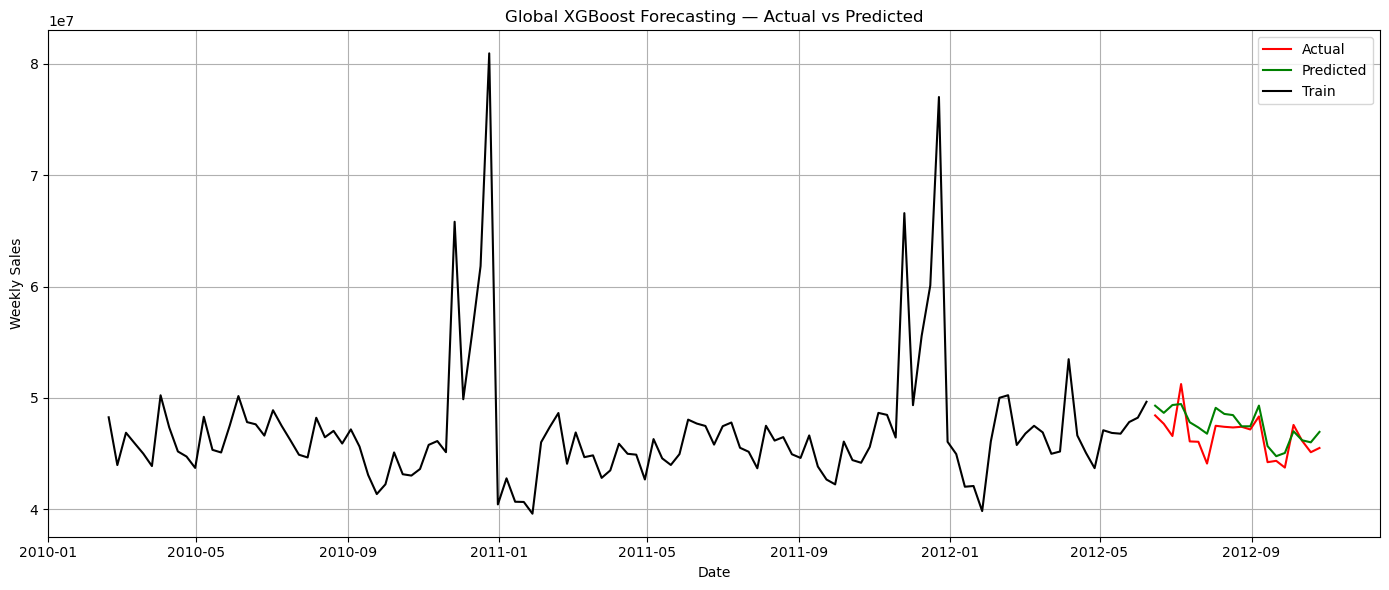

In [121]:
# PLOTTING
plt.figure(figsize=(14, 6))
plt.plot(grouped.index, grouped['Actual'], label='Actual', color='red')
plt.plot(grouped.index, grouped['Predicted'], label='Predicted', color='green')
plt.plot(train_grouped.index, train_grouped['Weekly_Sales_cleaned'], label='Train', color='black')
plt.title('Global XGBoost Forecasting — Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()